In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import func

from load_data import my_conn
from load_data.db_model.activity import Activity
from load_data.db_model.sensor_data import SensorData
from load_data.db_model.session import Session

db = my_conn.load_db()

In [10]:
sensor_data_count = (
    db.query(Session.subject_id, func.count("*"))
    .join(SensorData)
    .group_by(Session.subject_id)
    .order_by(Session.subject_id)
    .all()
)

df = pd.DataFrame(sensor_data_count, columns=["Subject_ID", "SensorData_Count"])
total_count = df["SensorData_Count"].sum()
total_df = pd.DataFrame([{"Subject_ID": "Total", "SensorData_Count": total_count}])
df = pd.concat([df, total_df])
print(df.to_string(index=False))

Subject_ID  SensorData_Count
         1             35174
         2             35532
         3             35380
         4             35328
         5             33947
         6             32205
         7             34253
         8             33332
         9             34354
        10             33690
     Total            343195


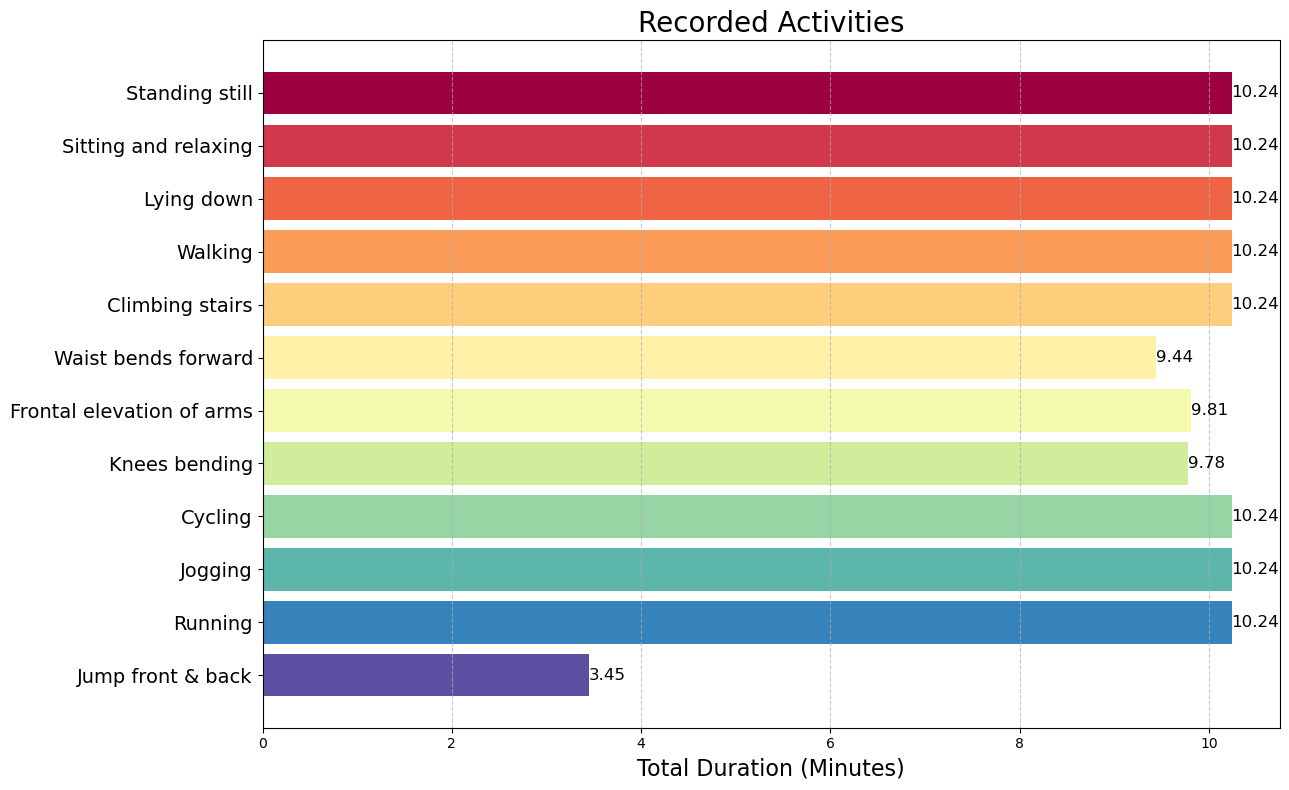

In [11]:
activity_count = (
    db.query(Activity.description, func.count(SensorData.sequence))
    .join(Session, Session.id == SensorData.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description, Activity.id)
    .order_by(Activity.id)
    .all()
)
db.close()

df = pd.DataFrame(activity_count, columns=["Activity", "Count"])
df["Duration"] = df["Count"] / 50 / 60

plt.figure(figsize=(13, 8))
colors = plt.get_cmap("Spectral")(np.linspace(0, 1, 10))
plt.barh(
    df["Activity"],
    df["Duration"],
    color=plt.colormaps["Spectral"](np.linspace(0, 1, len(df))),
)

plt.title("Recorded Activities", fontsize=20)
plt.xlabel("Total Duration (Minutes)", fontsize=16)
plt.yticks(fontsize=14)
for i, v in enumerate(df["Duration"]):
    plt.text(v, i, f"{v:.2f}", va="center", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

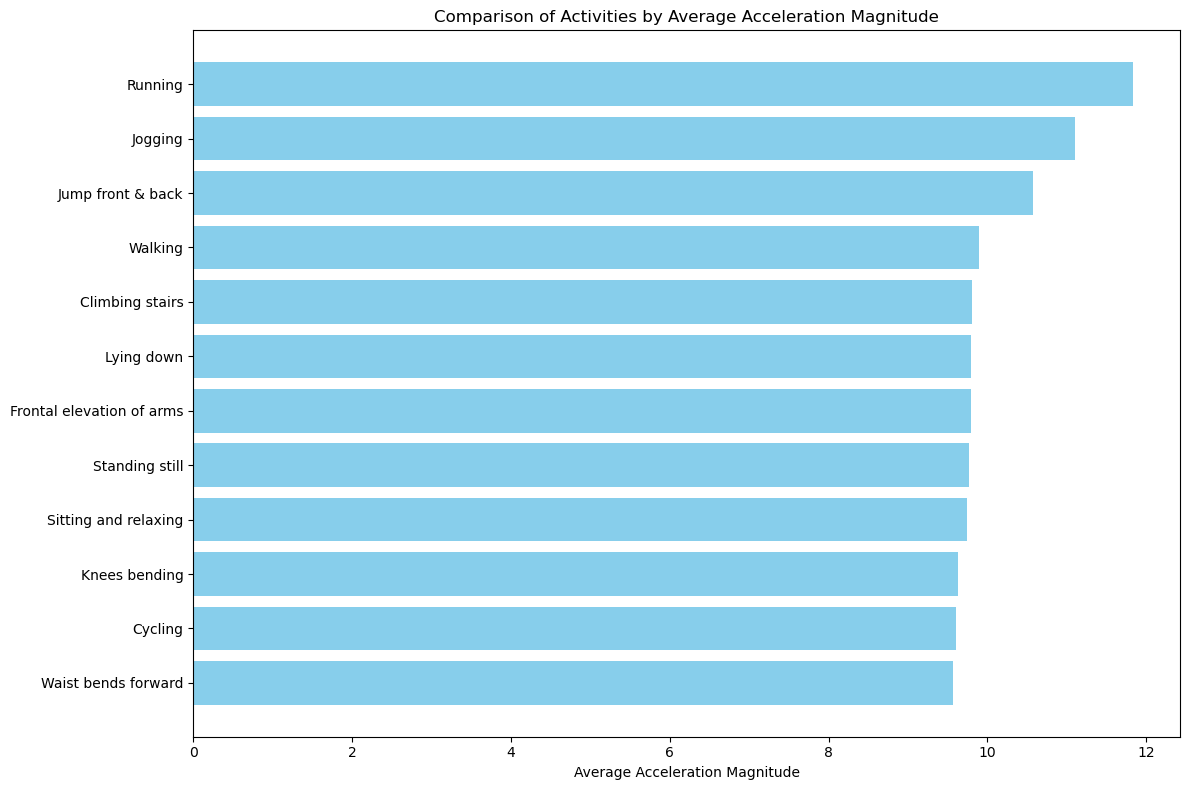

In [12]:
activity_sensor_stats = (
    db.query(
        Activity.description,
        func.avg(
            func.sqrt(
                func.pow(SensorData.acceleration_chest_x, 2)
                + func.pow(SensorData.acceleration_chest_y, 2)
                + func.pow(SensorData.acceleration_chest_z, 2)
            )
        ).label("avg_acceleration_magnitude"),
    )
    .join(Session, Session.id == SensorData.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description)
    .all()
)
db.close()

df_activity_stats = pd.DataFrame(
    activity_sensor_stats, columns=["Activity", "Average Acceleration Magnitude"]
)
df_activity_stats = df_activity_stats.sort_values(
    "Average Acceleration Magnitude", ascending=True
)

plt.figure(figsize=(12, 8))
plt.barh(
    df_activity_stats["Activity"],
    df_activity_stats["Average Acceleration Magnitude"],
    color="skyblue",
)
plt.xlabel("Average Acceleration Magnitude")
plt.title("Comparison of Activities by Average Acceleration Magnitude")
plt.tight_layout()
plt.show()